In [1]:
import sys
sys.path.append("/home/ubuntu/MultiModalDeepFake")
import nemo.collections.asr as nemo_asr 
import pandas as pd

/home/ubuntu/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
2023-04-05 18:45:34.606399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 18:45:34.716807: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-05 18:45:35.288040: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.c

In [2]:
from packages.LJDataLoader import LJDataLoader
from packages.AudioEmbeddingsManager import AudioEmbeddingsManager
from packages.ModelManager import ModelManager

## Generate the Train/Dev/Test

In [3]:
file_path = '/home/ubuntu/data/wavefake_data/LJ_metadata_16000KHz.csv'
loader = LJDataLoader(data_path=file_path)
loader.sample(0.1)
loader.splitData()

source_architectures = ['Full_Band_MelGan', 'HifiGan', 'MelGan', 'MelGanLarge', 'Multi_Band_MelGan', 'Parallel_WaveGan', 'Waveglow']
new_col_name = 'RandWaveFake'
loader.selectRandomArchitecture(target_col=new_col_name, source_cols=source_architectures)

#data_df = loader.generateFinalDataFrame(real_col='Real', fake_cols=['RandWaveFake', 'ElevenLabs', 'UberDuck'])
data_df = loader.generateFinalDataFrame(real_col='Real', fake_cols=['ElevenLabs', 'UberDuck'])

## Generate the Features

In [4]:
speaker_model = nemo_asr.models.EncDecSpeakerLabelModel.from_pretrained(model_name='titanet_large')

[NeMo I 2023-04-05 18:45:37 cloud:56] Found existing object /home/ubuntu/.cache/torch/NeMo/NeMo_1.15.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.
[NeMo I 2023-04-05 18:45:37 cloud:62] Re-using file from: /home/ubuntu/.cache/torch/NeMo/NeMo_1.15.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo
[NeMo I 2023-04-05 18:45:37 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2023-04-05 18:45:38 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /manifests/combined_fisher_swbd_voxceleb12_librispeech/train.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 3
    is_tarred: false
    tarred_audio_filepaths: null
    tarred_shard_strategy: scatter
    augmentor:
      noise:
        manifest_path: /manifests/noise/rir_noise_manifest.json
        prob: 0.5
        min_snr_db: 0
        max_snr_db: 15
      speed:
        prob: 0.5
        sr: 16000
        resample_type: kaiser_fast
        min_speed_rate: 0.95
        max_speed_rate: 1.05
    num_workers: 15
    pin_memory: true
    
[NeMo W 2023-04-05 18:45:38 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_valida

[NeMo I 2023-04-05 18:45:38 label_models:126] Setting angular: true/false in decoder is deprecated and will be removed in 1.13 version, use specific loss with _target_
[NeMo I 2023-04-05 18:45:38 features:267] PADDING: 16
[NeMo I 2023-04-05 18:45:39 save_restore_connector:243] Model EncDecSpeakerLabelModel was successfully restored from /home/ubuntu/.cache/torch/NeMo/NeMo_1.15.0/titanet-l/492c0ab8416139171dc18c21879a9e45/titanet-l.nemo.


In [5]:
embedding_manager = AudioEmbeddingsManager(model=speaker_model, data=data_df)

In [6]:
feature_df, feature_cols = embedding_manager.generateFeatureDf()

[NeMo W 2023-04-05 18:45:40 nemo_logging:349] /home/ubuntu/miniconda3/envs/nemo/lib/python3.8/site-packages/nemo/collections/asr/models/label_models.py:437: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525491394/work/torch/csrc/utils/tensor_new.cpp:230.)
      torch.tensor([audio], device=device),
    


In [7]:
feature_df.head()

,type,path,label,multiclass_label,0,1,2,3,4,5,...,182,183,184,185,186,187,188,189,190,191
0,train,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,0,0,0.001568,0.006491,0.003196,0.030693,-0.019937,0.024868,...,0.003872,0.012601,0.003832,0.011658,0.005086,0.023229,0.005407,0.014026,0.036624,0.002194
1,train,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,0,0,0.015822,-0.006878,0.001255,0.014363,-0.019334,0.028075,...,-0.006862,0.000704,-0.010912,-0.001890,0.012060,-0.004668,-0.006693,-0.007411,0.005939,-0.004142
2,train,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,0,0,-0.002206,0.046569,-0.013344,-0.006491,0.002782,-0.014770,...,-0.019305,0.005408,0.001435,0.015875,-0.002383,0.020489,0.011872,0.022551,-0.005581,0.005881
3,train,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,0,0,-0.003289,0.012249,0.002246,0.026558,-0.008520,0.016931,...,-0.027556,0.022622,-0.017284,-0.013891,0.008302,0.019465,0.001016,0.015241,0.011833,-0.005732
4,train,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,0,0,0.009101,0.019122,-0.000536,-0.005119,-0.038450,0.021211,...,-0.002042,0.007567,-0.003800,-0.018021,0.004873,0.011547,-0.006656,0.006623,0.000861,0.003502


## Predict and Evaluate

In [8]:
model_manager = ModelManager('logreg', feature_df, feature_cols, merge_train_dev=True)

In [9]:
acc, logloss = model_manager.trainPredict(label_col='multiclass_label')

In [10]:
#model_manager.plotRocCurve()

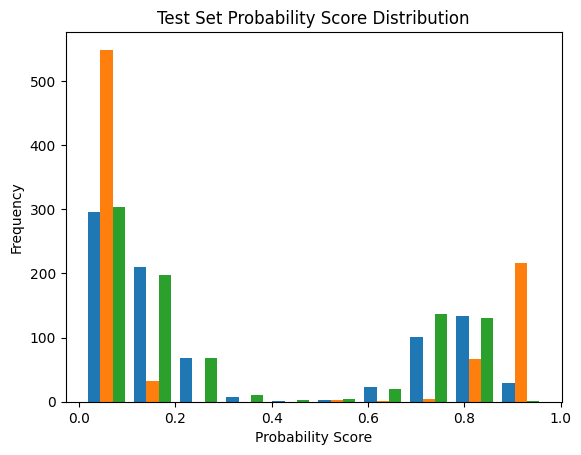

In [11]:
model_manager.plotProbaDistribution()

In [12]:
print(acc, logloss)

0.9988545246277205 0.21852463819778978
